# Running notes 


## Filtering 
Ice and land masking is not perfect. There are a handful of cutouts with land and more with ice. Removing them from this dataset still leaves us with 93k. Mostly ice is the problem. There are very few cutouts with land. 

In [2]:
import dbof.dataset_creation.zarr_dataset as zarr_dataset
import dbof.io.filesystems as filesystems

In [3]:
import cartopy.crs as ccrs

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from dask.distributed import Client
import torch
from torch.utils.data import Dataset, DataLoader

In [12]:
# follow link for a progress bar in following steps
client = Client()
client
# client.cluster.scale(4) # less workers and more memory
port = client.scheduler_info()["services"]["dashboard"]
# For nrp link is :
#https://jupyterhub-west.nrp-nautilus.io/hub/user-redirect/proxy/{port}/status
print(f"url : https://jupyterhub-west.nrp-nautilus.io/hub/user-redirect/proxy/{port}/status")

/home/jovyan/conda_envs/dbof_training/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33373 instead
  warnings.warn(


url : https://jupyterhub-west.nrp-nautilus.io/hub/user-redirect/proxy/33373/status


2026-02-19 20:50:17,093 - tornado.application - ERROR - Uncaught exception GET /status/ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='jupyterhub-west.nrp-nautilus.io', method='GET', uri='/status/ws', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/home/jovyan/conda_envs/dbof_training/lib/python3.12/site-packages/tornado/websocket.py", line 965, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/conda_envs/dbof_training/lib/python3.12/site-packages/tornado/web.py", line 3388, in wrapper
    return method(self, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/conda_envs/dbof_training/lib/python3.12/site-packages/bokeh/server/views/ws.py", line 149, in open
    raise ProtocolError("Token is expired. Configure the app with a larger value for --session-token-expiration if nece

In [ ]:
bucket = "dbof" #data_cfg["bucket"]
folder = "native_grid_dbof_training_data"
s3_endpoint = "https://s3-west.nrp-nautilus.io"
feature_channels = ['Eta', 'Salt', 'Theta', 'U', 'V', 'W', 'relative_vorticity', 'log_gradb']
run_id = "big_run_00"

fs, fs_synch = filesystems.create_s3_filesystems(s3_endpoint)

reader = zarr_dataset.ZarrDatasetReader(
    bucket=bucket,
    folder=folder,
    run_id=run_id,
    dataset_name="dataset_creation.zarr",
    fs=fs
)

In [14]:
images_da, ids_da, valid_mask_da = reader.full_dataset_as_dask()
images_np = images_da.compute()

In [17]:
images_np.shape

(102000, 8, 64, 64)

In [18]:
from tqdm import tqdm

# Filter bad cutouts 

In [59]:
theta = images_np[:, 2]   # (N, 64, 64)

print("Any NaN:", np.isnan(theta).any())
print("Any +inf:", np.isposinf(theta).any())
print("Any -inf:", np.isneginf(theta).any())

print("Total NaNs:", np.isnan(theta).sum())
print("Total infs:", np.isinf(theta).sum())

# Boolean mask: True if patch has any NaN
bad_patch_mask = np.isnan(theta).reshape(theta.shape[0], -1).any(axis=1)

num_bad = bad_patch_mask.sum()
print("Number of patches containing NaN:", num_bad)

bad_indices = np.where(bad_patch_mask)[0]
print("First 10 bad patch indices:", bad_indices[:10])

Any NaN: True
Any +inf: False
Any -inf: False
Total NaNs: 2642
Total infs: 0
Number of patches containing NaN: 108
First 10 bad patch indices: [3078 4045 4103 4403 4535 5190 5769 5843 6437 8951]


(64, 64)


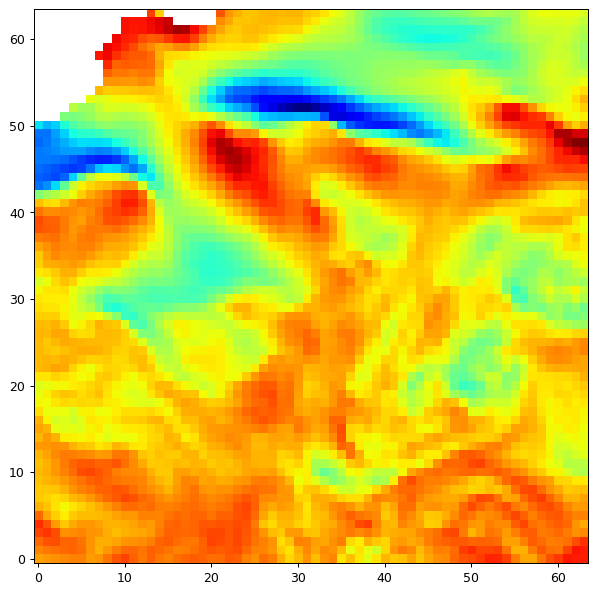

In [60]:
img = images_np[6437, 3, :,:]
print(img.shape)
plt.figure(figsize=(8,8), dpi= 90)
plt.imshow(img,origin='lower',cmap='jet')


In [63]:
# NOTE this ruins the indexing system. 
# Image Ids need to be removed for these indexes as well todo 
N = images_np.shape[0]

keep_mask = np.ones(N, dtype=bool)
keep_mask[bad_indices] = False

images_clean_np = images_np[keep_mask]

print("Old shape:", images_np.shape)
print("New shape:", images_clean_np.shape)

Old shape: (102000, 8, 64, 64)
New shape: (101892, 8, 64, 64)


# Global Analysis on our Data

Todo maybe

Global θ PDF (subsampled, log-scale)

Global summary stats (mean, std, skew, percentiles)

Per-patch mean distribution

Per-patch std distribution

Per-patch min/max distribution

Gradient magnitude distribution

2D power spectrum (radial average)

Mean θ vs latitude

Variance vs latitude

Seasonal distribution comparison (if applicable)

PCA on flattened patches (eigenvalue spectrum)

Random patch visualization (fixed color scale)

In [64]:
def global_histogram(
    images_np,
    title,
    channel=0,
    log=True,
    bins=200
):
    """
    images_np: numpy array (N, C, H, W)
    """

    N = images_da.shape[0]

    #patch_idx = np.random.choice(N, size=min(n_patches, N), replace=False)

    samples = []

    # for i in tqdm(patch_idx):
    for i in tqdm(range(len(images_np))):
        # Only compute one patch at a time
        patch = images_np[i, channel]  # (64,64)

        flat = patch.ravel()
        samples.append(flat)

    samples = np.concatenate(samples)
    print(samples[0])

    print(f"Total sampled points: {samples.size}")
    print(f"Mean: {samples.mean():.3f}")
    print(f"Std: {samples.std():.3f}")
    print(f"1–99 percentile: {np.percentile(samples,[1,99])}")

    plt.figure(figsize=(6,4))
    plt.hist(samples, bins=bins, density=True, log=log)
    plt.xlabel("Theta")
    plt.ylabel("PDF (log scale)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

## Theta

In [71]:
theta = images_clean_np[:, 2]   # (N, 64, 64)

100%|██████████| 101892/101892 [00:00<00:00, 1936587.02it/s]


3.3369255
Total sampled points: 417349632
Mean: 15.415
Std: 8.913
1–99 percentile: [-0.9833277  29.29665947]


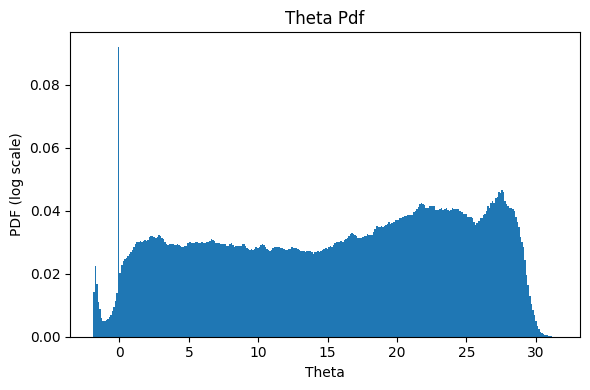

In [66]:
global_histogram(images_clean_np,"Theta Pdf", channel=2,log=False, bins=300)

In [75]:
# ice???
bad_mask = (theta <= 0).any(axis=(1, 2))

count = bad_mask.sum()
ice_indices = np.where(bad_mask)[0]

print(count)
print(ice_indices[:10])

8328
[  0  19  24  52  57 109 126 138 156 171]


(64, 64)


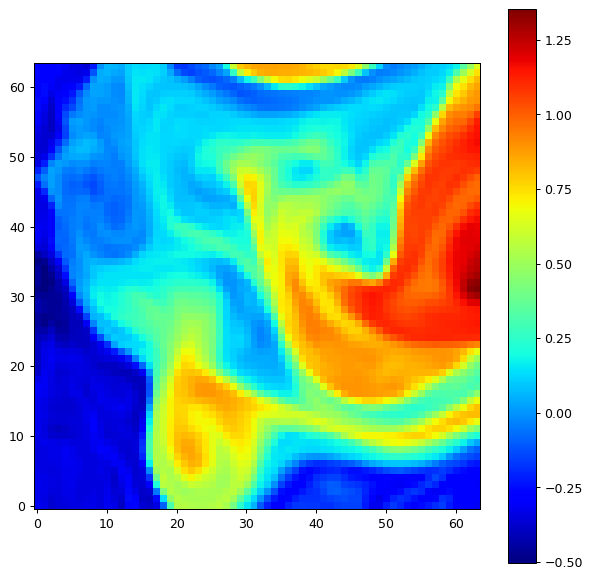

In [74]:
img = images_np[52, 2, :,:]
print(img.shape)
plt.figure(figsize=(8,8), dpi= 90)

im = plt.imshow(img, origin='lower', cmap='jet')
plt.colorbar(im)   # attach colorbar to this image

plt.show()

In [76]:
# NOTE this ruins the indexing system. 
# Image Ids need to be removed for these indexes as well todo 
N = images_clean_np.shape[0]

keep_mask = np.ones(N, dtype=bool)
keep_mask[ice_indices] = False

images_clean_no_ice_np = images_clean_np[keep_mask]

print("Old shape:", images_clean_np.shape)
print("New shape:", images_clean_no_ice_np.shape)

Old shape: (101892, 8, 64, 64)
New shape: (93564, 8, 64, 64)


100%|██████████| 93564/93564 [00:00<00:00, 1970366.17it/s]


15.396468
Total sampled points: 383238144
Mean: 16.677
Std: 8.160
1–99 percentile: [ 1.30773449 29.33666992]


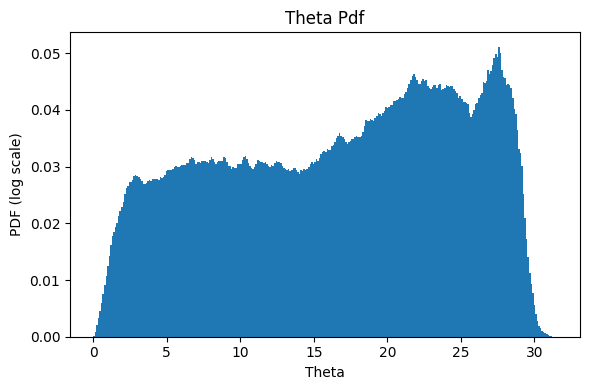

In [85]:
global_histogram(images_clean_no_ice_np,"Theta Pdf", channel=2,log=False, bins=300)

In [7]:
files = fs_synch.glob(
    f"{bucket}/{folder}/{run_id}/metadata/*.parquet"
)

meta_df = pd.read_parquet(files, filesystem=fs_synch)

C:\Users\Jake Tallman\PycharmProjects\DBOF_Representation_Learning\.venv\Lib\site-packages\cartopy\mpl\geoaxes.py:1677: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  result = super().scatter(*args, **kwargs)


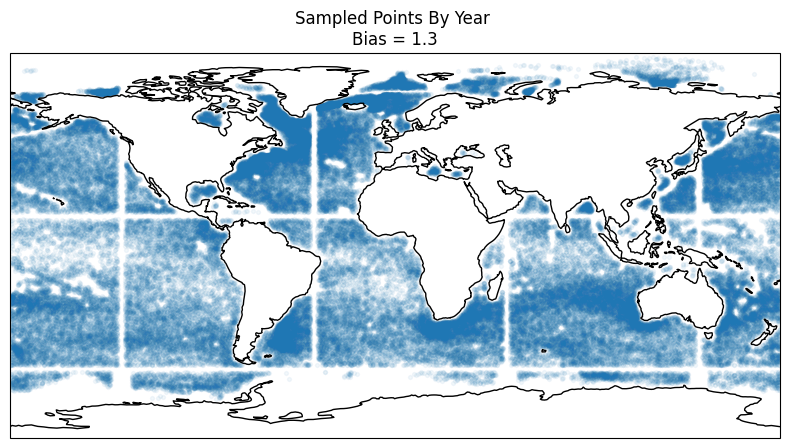

In [13]:
lats = meta_df["center_lat"].values
lons = meta_df["center_lon"].values


cmap = plt.get_cmap("tab10")

fig = plt.figure(figsize=(11, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_global()
ax.coastlines()

sc = ax.scatter(
    lons,
    lats,
    cmap=cmap,
    s=8,
    alpha=0.05,
    transform=ccrs.PlateCarree()
)

plt.title("Sampled Points By Year \nBias = 1.3")
plt.show()

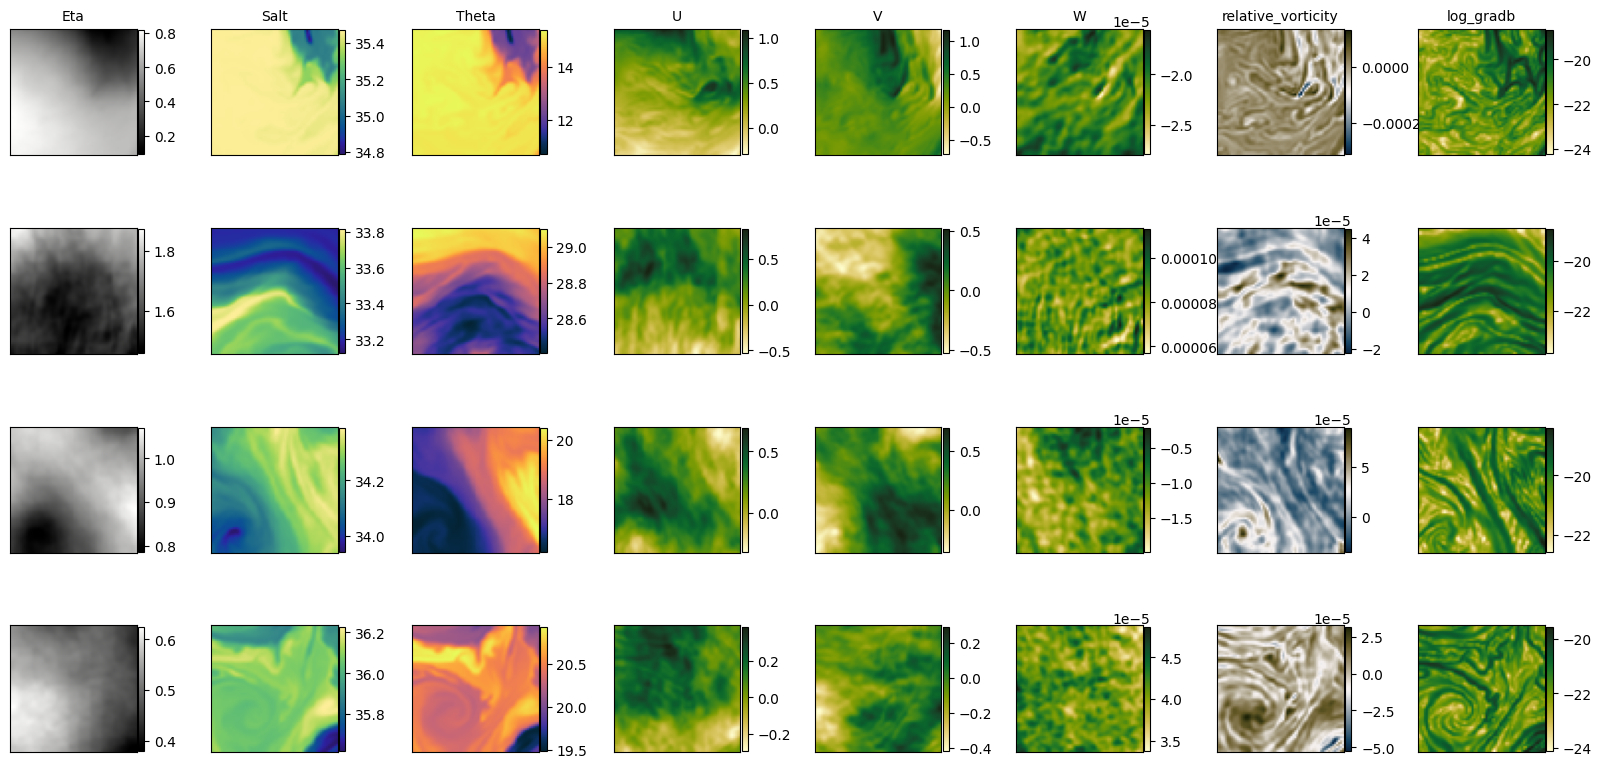

,dataset_index,id,native_grid,center_grid_face,center_grid_j,center_grid_i,center_lat,center_lon,target_km_res,real_km_w,real_km_h,pre_interp_res,log_grad_b_2_center,time_snapshot
0,b'1b32ed69d86445df8b2061a8962d30f5',93b10880-1497-42f9-8493-fa7383fe5b40,LLC4320,4,1383,157,-39.124081,55.281250,150,147.342729,147.956544,"[90, 83]",-20.879079,2012-09-16 19:00:00
1,b'4712b4ccfb7c47498d6c127dd37d773d',bf1d089c-3e17-40d6-9f5a-76ad02255962,LLC4320,5,313,4016,19.493999,135.677078,150,148.472887,148.581832,"[75, 69]",-19.271278,2012-09-30 07:00:00
2,b'6ca518c97bc145ef945bee1cd7670d31',280ecbfa-3193-4ae8-8194-11fe6f658582,LLC4320,7,2091,3066,35.403271,-174.427078,150,148.006906,147.257782,"[79, 86]",-19.353220,2012-06-07 13:00:00
3,b'b8ad0a1abb064da3a7c7a66e7b86fa0d',af251ce3-3490-4448-bd21-11c1cad600d6,LLC4320,1,2002,654,-29.314280,-24.364584,150,149.450552,148.605251,"[81, 75]",-20.235913,2012-06-17 16:00:00


In [14]:
import cmocean


def plot_image_features(imgs, ids):
    """
    imgs: (N, C, H, W)
    """

    N, C, H, W = imgs.shape

    fig = plt.figure(figsize=(2.5*(C+1), 2.5*N))
    gs = fig.add_gridspec(N, C + 1, wspace=0.5, hspace=0.15)

    for i in range(N):
        row_data = imgs[i]

        for c in range(C):
            ax = fig.add_subplot(gs[i, c])

            # vmin = np.nanmin(row_data[c])
            # vmax = np.nanmax(row_data[c])


            if c == 0:
                cmap = cmocean.cm.gray
            elif c == 1 :
                cmap = cmocean.cm.haline
            elif c == 2 :
                cmap = cmocean.cm.thermal
            elif c == 6 :
                cmap = cmocean.cm.diff
            else :
                cmap = cmocean.cm.speed



            im = ax.imshow(row_data[c], cmap=cmap) #, vmin=vmin, vmax=vmax)
            ax.set_xticks([])
            ax.set_yticks([])

            if i == 0:
                ax.set_title(f"{feature_channels[c]}", fontsize=10)

            fig.colorbar(
                im,
                ax=ax,
                fraction=0.046,
                pad=0.01 #format="%4.2"
            )

    plt.show()

rand_indices = np.random.randint(0, reader.num_images, size=4)
imgs, ids = reader.get_images(rand_indices)

plot_image_features(imgs, ids)

# Metadata for each sample
subset_df = (
    meta_df
    .set_index("dataset_index")
    .loc[ids]
    .reset_index()
)
subset_df